# Advanced EDA - Market Insights, Affinity & Remote Trends

This notebook focuses on extracting conclusive insights and identifying correlations within the job market data.

**Objectives:**
1. **Role Affinity:** Analyze how roles overlap.
2. **Seniority Analysis:** Identify seniority demands by role/country.
3. **Remote Work Detection:** Search descriptions for remote/hybrid patterns.
4. **Market Concentration:** Analyze company dominance in specific markets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

sns.set_theme(style="whitegrid")
pd.set_option('display.max_colwidth', 100)

## 1. Load Data with Descriptions

We need the descriptions to detect remote/hybrid keywords effectively.

In [2]:
df = pd.read_csv("../data/interim/all_jobs_merged.csv")
df['created'] = pd.to_datetime(df['created'])
df['company'] = df['company'].fillna('Unknown')
df['description'] = df['description'].fillna('')
print(f"Loaded Shape: {df.shape}")

Loaded Shape: (39844, 9)


## 2. Seniority Extraction

We will identify seniority levels from the job titles using regex.

C:\Users\bnove\AppData\Local\Temp\ipykernel_6572\3376404107.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='seniority', order=order, palette='viridis')


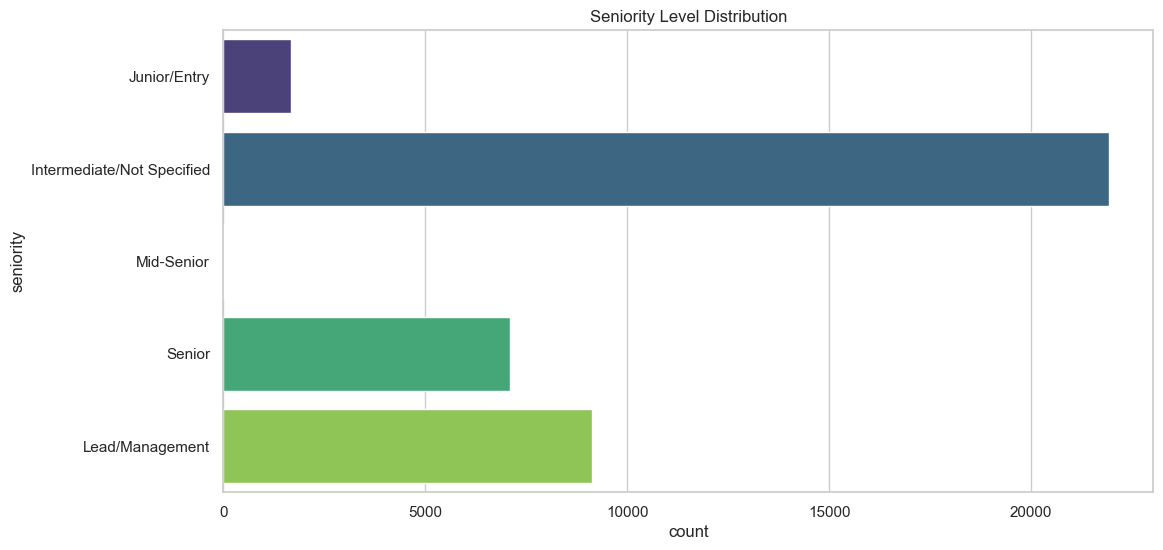

In [3]:
def extract_seniority(title):
    title = str(title).lower()
    if re.search(r'\b(lead|head|manager|director|principal|staff|chief)\b', title):
        return 'Lead/Management'
    if re.search(r'\b(senior|sr|expert|advanced)\b', title):
        return 'Senior'
    if re.search(r'\b(junior|jr|entry|intern|trainee|graduate)\b', title):
        return 'Junior/Entry'
    if re.search(r'\b(semi-senior|ssr|middle)\b', title):
        return 'Mid-Senior'
    return 'Intermediate/Not Specified'

df['seniority'] = df['title'].apply(extract_seniority)

plt.figure(figsize=(12, 6))
order = ['Junior/Entry', 'Intermediate/Not Specified', 'Mid-Senior', 'Senior', 'Lead/Management']
sns.countplot(data=df, y='seniority', order=order, palette='viridis')
plt.title('Seniority Level Distribution')
plt.show()

## 3. Remote & Hybrid Detection

We look for specific keywords in both location and description.

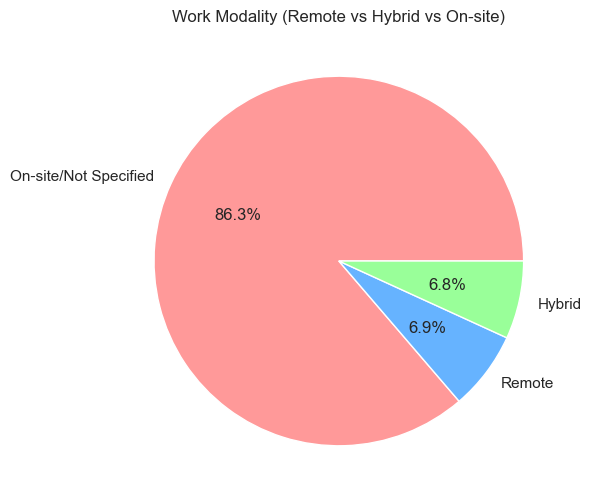

In [4]:
remote_keywords = r'remote|remoto|teletrabajo|home office|work from home|wfh|anywhere|distributed'
hybrid_keywords = r'hybrid|hibrido|híbrido|flexible|mix'

def detect_modality(row):
    text = (str(row['location']) + " " + str(row['description'])).lower()
    if re.search(remote_keywords, text):
        return 'Remote'
    if re.search(hybrid_keywords, text):
        return 'Hybrid'
    return 'On-site/Not Specified'

df['modality'] = df.apply(detect_modality, axis=1)

plt.figure(figsize=(10, 6))
df['modality'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Work Modality (Remote vs Hybrid vs On-site)')
plt.ylabel('')
plt.show()

## 4. Role Affinity (Co-occurrence)

We analyze how different roles are combined in a single posting.

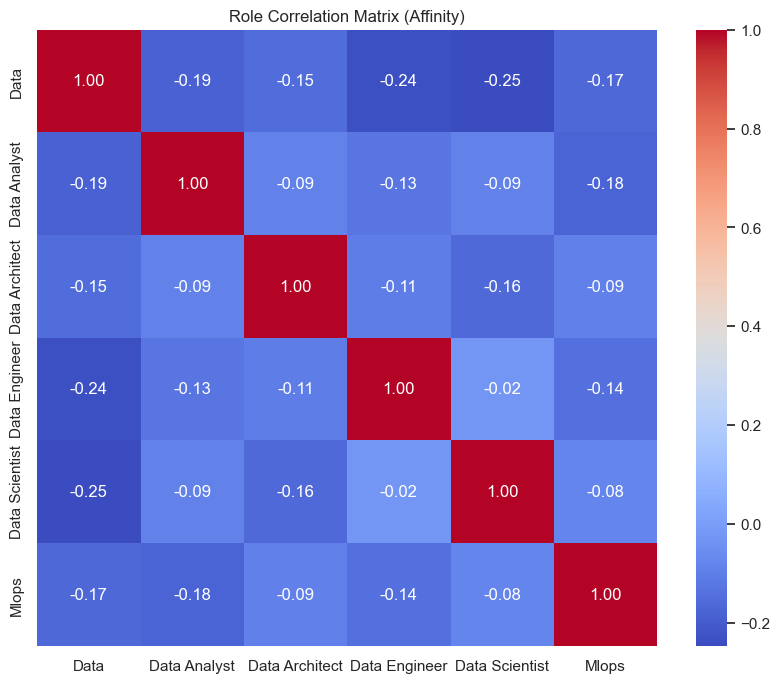

In [5]:
role_data = df.groupby('id')['search_term'].apply(lambda x: list(set(x.dropna()))).reset_index()
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
role_matrix = mlb.fit_transform(role_data['search_term'])
role_df = pd.DataFrame(role_matrix, columns=mlb.classes_)

correlation_matrix = role_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Role Correlation Matrix (Affinity)')
plt.show()

## 5. Market Concentration (Gini Coefficient per Country)

We calculate how concentrated the job market is. A high Gini means few companies dominate all offers.

C:\Users\bnove\AppData\Local\Temp\ipykernel_6572\1854243724.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gini_df, x='country', y='gini', palette='viridis')


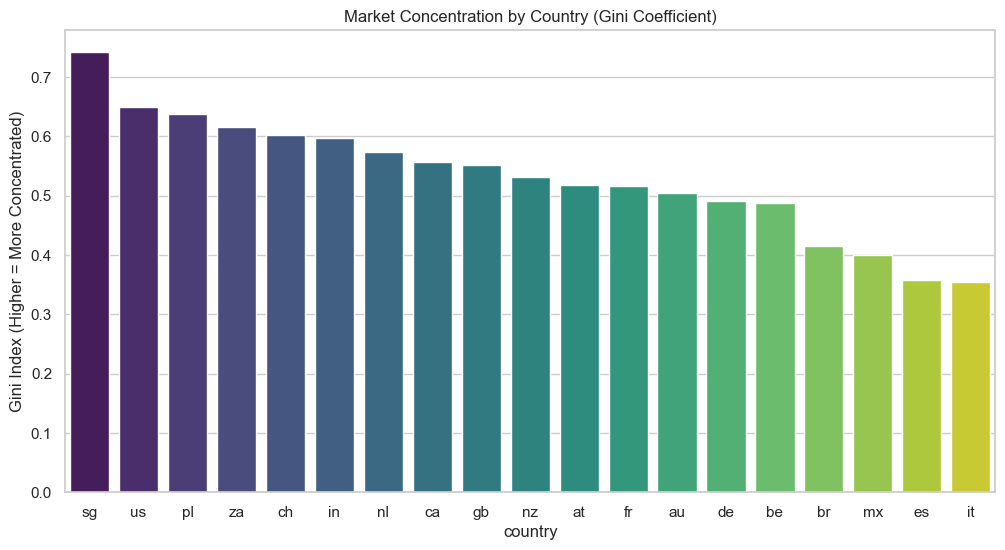

In [6]:
def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    return 0.5 * rmad

concentration = []
for country in df['country_code'].unique():
    counts = df[df['country_code'] == country]['company'].value_counts().values
    if len(counts) > 1:
        concentration.append({'country': country, 'gini': gini(counts)})

gini_df = pd.DataFrame(concentration).sort_values('gini', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=gini_df, x='country', y='gini', palette='viridis')
plt.title('Market Concentration by Country (Gini Coefficient)')
plt.ylabel('Gini Index (Higher = More Concentrated)')
plt.show()

## 6. Years of Experience Analysis

We extract experience requirements from descriptions using regex and bucket them.

C:\Users\bnove\AppData\Local\Temp\ipykernel_6572\2666793476.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='exp_bucket', order=order, palette='magma')


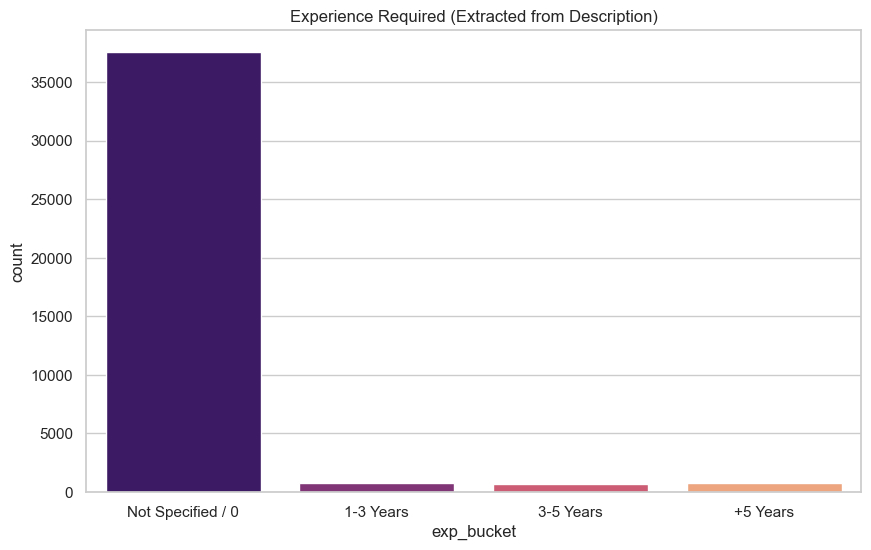

In [7]:
def extract_years(text):
    text = str(text).lower()
    # Regex capturing the first digit of 'N years' patterns
    # Handles '3 years', '3-5 years', '3+ years', '3 años'
    import re
    matches = re.findall(r'(\d+)(?:\s*-\s*\d+)?\s*(?:\+|plus)?\s*(?:years?|yrs?|años?|ans?)', text)
    if matches:
        try:
            nums = [int(m) for m in matches]
            # Filter out unreasonable numbers (e.g. 2023 years)
            nums = [n for n in nums if n < 20]
            if nums:
                return min(nums)
        except:
            return 0
    return 0

df['exp_years'] = df['description'].apply(extract_years)

def bucket_exp(y):
    if y == 0: return 'Not Specified / 0'
    if y <= 3: return '1-3 Years'
    if y <= 5: return '3-5 Years'
    return '+5 Years'

df['exp_bucket'] = df['exp_years'].apply(bucket_exp)

plt.figure(figsize=(10, 6))
order = ['Not Specified / 0', '1-3 Years', '3-5 Years', '+5 Years']
sns.countplot(data=df, x='exp_bucket', order=order, palette='magma')
plt.title('Experience Required (Extracted from Description)')
plt.show()

## 6. Years of Experience Analysis

We extract experience requirements from descriptions using regex and bucket them.

In [ ]:
def extract_years(text):
    text = str(text).lower()
    # Regex capturing the first digit of 'N years' patterns
    # Handles '3 years', '3-5 years', '3+ years', '3 años'
    import re
    matches = re.findall(r'(\d+)(?:\s*-\s*\d+)?\s*(?:\+|plus)?\s*(?:years?|yrs?|años?|ans?)', text)
    if matches:
        try:
            nums = [int(m) for m in matches]
            # Filter out unreasonable numbers (e.g. 2023 years)
            nums = [n for n in nums if n < 20]
            if nums:
                return min(nums)
        except:
            return 0
    return 0

df['exp_years'] = df['description'].apply(extract_years)

def bucket_exp(y):
    if y == 0: return 'Not Specified / 0'
    if y <= 3: return '1-3 Years'
    if y <= 5: return '3-5 Years'
    return '+5 Years'

df['exp_bucket'] = df['exp_years'].apply(bucket_exp)

plt.figure(figsize=(10, 6))
order = ['Not Specified / 0', '1-3 Years', '3-5 Years', '+5 Years']
sns.countplot(data=df, x='exp_bucket', order=order, palette='magma')
plt.title('Experience Required (Extracted from Description)')
plt.show()

## 6. Years of Experience Analysis

We extract experience requirements from descriptions using regex and bucket them.

In [ ]:
def extract_years(text):
    text = str(text).lower()
    # Regex capturing the first digit of 'N years' patterns
    # Handles '3 years', '3-5 years', '3+ years', '3 años'
    import re
    matches = re.findall(r'(\d+)(?:\s*-\s*\d+)?\s*(?:\+|plus)?\s*(?:years?|yrs?|años?|ans?)', text)
    if matches:
        try:
            nums = [int(m) for m in matches]
            # Filter out unreasonable numbers (e.g. 2023 years)
            nums = [n for n in nums if n < 20]
            if nums:
                return min(nums)
        except:
            return 0
    return 0

df['exp_years'] = df['description'].apply(extract_years)

def bucket_exp(y):
    if y == 0: return 'Not Specified / 0'
    if y <= 3: return '1-3 Years'
    if y <= 5: return '3-5 Years'
    return '+5 Years'

df['exp_bucket'] = df['exp_years'].apply(bucket_exp)

plt.figure(figsize=(10, 6))
order = ['Not Specified / 0', '1-3 Years', '3-5 Years', '+5 Years']
sns.countplot(data=df, x='exp_bucket', order=order, palette='magma')
plt.title('Experience Required (Extracted from Description)')
plt.show()